In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D

from astropy.stats import mad_std

import cometToolkit as ctk

from astropy.nddata import Cutout2D

# Finding ZeroPoint

In [2]:
vReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day12/V/*"))[:-2]
rReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day12/R/*"))[:-2]
bReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day12/B/*"))[:-2]

In [3]:
vStackedStars = ctk.StackImages(vReducedDataPaths)
rStackedStars = ctk.StackImages(rReducedDataPaths)
bStackedStars = ctk.StackImages(bReducedDataPaths)

(array([], dtype=int64),)


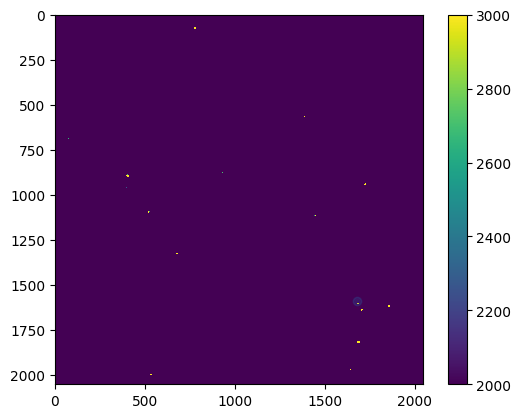

In [14]:
# Use to manually find star locations

sources = ctk.SearchStars(rStackedStars, showPlot=False)

plt.imshow(rStackedStars, vmin=2000, vmax=3000)
plt.colorbar()

# Finding stars
starCentre = (1680, 1590)
tolerance = 20
referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
print(referenceStarIndices)
plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")
sources[referenceStarIndices]
plt.scatter(starCentre[0], starCentre[1], alpha=0.2)

[10.315089, 12.10399, 11.612345]


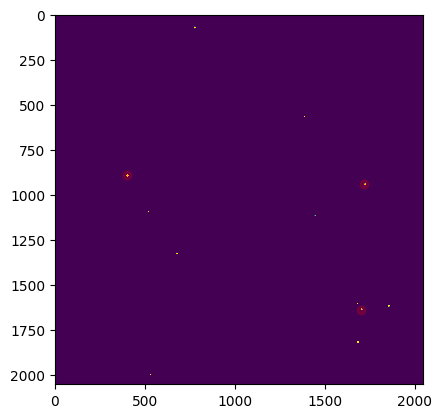

In [15]:
coordinates = np.array([(400, 890), (1720, 940), (1700, 1640)])

# Calibration from APASS9
vCalibratedMagnitudes = [10.753, 12.376, 11.849]
bCalibratedMagnitudes = [11.687, 12.932, 12.3]

# Sloan r to Johnsons R
# Jordi et al.
# https://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006
def JohnsonsR(sloan_r, sloan_i):
    # Note there are uncertainties on these transformations
    # Which can be included
    return -0.153 * (sloan_r - sloan_i) - 0.117 + sloan_r

sloan_r = [10.476, 12.247, 11.75]
sloan_i = [10.189, 12.077, 11.615]

rCalibratedMagnitudes = [JohnsonsR(r, i) for r, i in zip(sloan_r, sloan_i)]

print(rCalibratedMagnitudes)

plt.imshow(vStackedStars, vmin=2000, vmax=3000)
plt.scatter(coordinates[:,0], coordinates[:,1], alpha=0.2, color="red")

In [16]:
vZeroPoint = np.mean(ctk.DetermineStarZeroPoint(vStackedStars, len(vReducedDataPaths), coordinates, vCalibratedMagnitudes, apertureRadius=10))
print(vZeroPoint)
rZeroPoint = np.mean(ctk.DetermineStarZeroPoint(rStackedStars, len(vReducedDataPaths), coordinates, rCalibratedMagnitudes, apertureRadius=10))
print(rZeroPoint)
bZeroPoint = np.mean(ctk.DetermineStarZeroPoint(bStackedStars, len(vReducedDataPaths), coordinates, bCalibratedMagnitudes, apertureRadius=10))
print(bZeroPoint)

19.239865222246785
19.43489352711701
18.882780351920577


# Aperture Curve

In [17]:
vImageStacked = ctk.GetImage("../DataProducts/vStacked.fits")
rImageStacked = ctk.GetImage("../DataProducts/rStacked.fits")
bImageStacked = ctk.GetImage("../DataProducts/bStacked.fits")

In [18]:
def FindComet(image):
    sources = ctk.SearchStars(image, showPlot=False)

    tolerance = 20
    posX, posY = (925, 925)
    

    indices = np.where((abs(sources["xcentroid"] - posX) < tolerance) & (abs(sources["ycentroid"] - posY) < tolerance))
    comet = sources[indices]

    print(comet)

    return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))

cometV = FindComet(vImageStacked)
cometR = FindComet(rImageStacked)
cometB = FindComet(bImageStacked)

 id    xcentroid         ycentroid     ...        flux               mag        
--- ---------------- ----------------- ... ------------------ ------------------
 22 926.602471903746 926.3905848708093 ... 110.41799159343608 -5.107599608599216


/tmp/ipykernel_1901267/3936633529.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


 id     xcentroid         ycentroid     ...        flux              mag        
--- ----------------- ----------------- ... ----------------- ------------------
 35 926.5081837834687 926.2632181344708 ... 149.0874793667838 -5.433602930392366


/tmp/ipykernel_1901267/3936633529.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


 id     xcentroid         ycentroid     ...        flux              mag        
--- ----------------- ----------------- ... ----------------- ------------------
166 926.3730067983223 926.3796621451884 ... 186.7345951518858 -5.678061961071579


/tmp/ipykernel_1901267/3936633529.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


In [19]:
# Activity
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd
from sbpy.activity import Afrho

import astropy.units as u

# Function to do this for range of apertures

In [20]:
def FindActivityCurve(image, comet, apertureRangeKm, zeroPoint, showPlot=False):
    
    activity = []
    cometDistance = 0.585 * 1.496e8 # au to km

    for aKm in apertureRangeKm:
        # Convert aperture range from km to pixel
        aPixel = (180 * 3600) / (0.6 * np.pi) * np.arctan2(aKm, cometDistance)

        # Create aperture
        aperture = CircularAperture((comet[0], comet[1]), r=aPixel)

        # Find background
        background = Background2D(image, 50).background

        if showPlot:
            # Plot
            fig, ax = plt.subplots()

            ax.imshow(image - background, vmin=0, vmax=80)
            apertureCircle = plt.Circle((comet[0], comet[1]), aPixel, color="white", fill = 0)

            ax.add_patch(apertureCircle)

        phot_table = aperture_photometry(image - background, aperture)
        
        # find magnitude within aperture
        mag = -2.5 * np.log10(phot_table["aperture_sum"] / 120) + zeroPoint

        wavelength = 0.5501 * u.um

        mag = mag * u.ABmag # absolute magnitude
        #print(mag)

        aper = aKm * u.km

        eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

        afrho = Afrho.from_fluxd(wavelength, mag, aper, eph)
        
        activity.append(afrho.value)
        #print(afrho)

    return [apertureRangeKm, activity]

In [21]:
apertureRange = np.linspace(500, 25000, 15)

In [22]:
apRange, activityV = FindActivityCurve(vImageStacked, cometV, apertureRange, zeroPoint=vZeroPoint, showPlot=False)

In [23]:
apRange, activityR = FindActivityCurve(rImageStacked, cometR, apertureRange, zeroPoint=vZeroPoint, showPlot=False)

In [24]:
apRange, activityB = FindActivityCurve(bImageStacked, cometB, apertureRange, zeroPoint=vZeroPoint, showPlot=False)

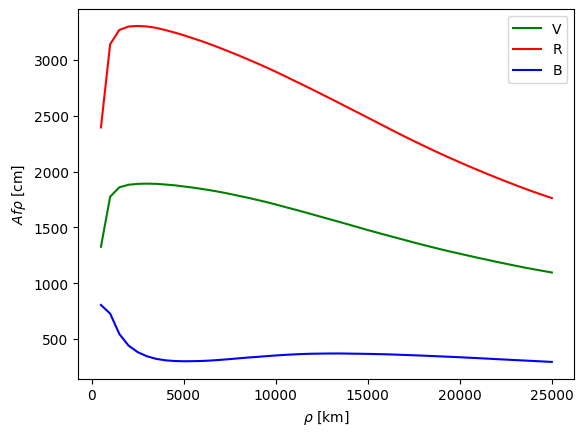

In [25]:
ctk.PlotAfrho(apRange, activityV, activityR, activityB)